predictive models:
- adaptive xgboost (AXGB)
- Hoeffding adaptive tree (HAT; pairs ADWIN drift detector with VFDT)

probabalistic models:
- markov switching model

feature selection:
- bayesian structural time series (BSTS)
- dynamic time warping

In [12]:
import pandas as pd
import numpy as np
data = pd.read_csv('data_pivot.csv')

In [2]:
data

,Cocoa,Coffee,Cotton,Orange Juice,Lumber,Sugar
0,830.0,116.500000,51.070000,NaN,NaN,NaN
1,836.0,116.250000,50.730000,NaN,NaN,NaN
2,831.0,118.599998,51.560001,NaN,NaN,NaN
3,841.0,116.849998,52.080002,NaN,NaN,NaN
4,853.0,114.150002,53.959999,NaN,NaN,NaN
...,...,...,...,...,...,...
6157,9659.0,227.149994,69.940002,429.200012,NaN,18.980000
6158,9938.0,226.300003,71.029999,413.649994,NaN,18.920000
6159,9598.0,230.250000,70.849998,422.250000,NaN,18.889999
6160,8995.0,226.550003,68.190002,427.850006,NaN,18.969999


### Vanilla model

#### Next day prediction

We need to reformat our data such that it's appropriate for a supervised learning task. The target y (the next future value of the series) must be predicted from the current value of the target series. We will include the other commodities (except orange juice) as additional predictors. 

cv 1:
train index: 0-1012
test index: 1013-2020
mae: 1.1579809401716505

cv 2:
train index: 0-2020
test index: 2021-3028
mae: 4.326419146288009

cv 3:
train index: 0-3028
test index: 3029-4036
mae: 0.2546793392726353

cv 4:
train index: 0-4036
test index: 4037-5044
mae: 0.22738323798255314

cv 5:
train index: 0-5044
test index: 5045-6052
mae: 0.2885760967693633



C:\Users\Melanie\AppData\Local\Temp\ipykernel_18024\3702819843.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


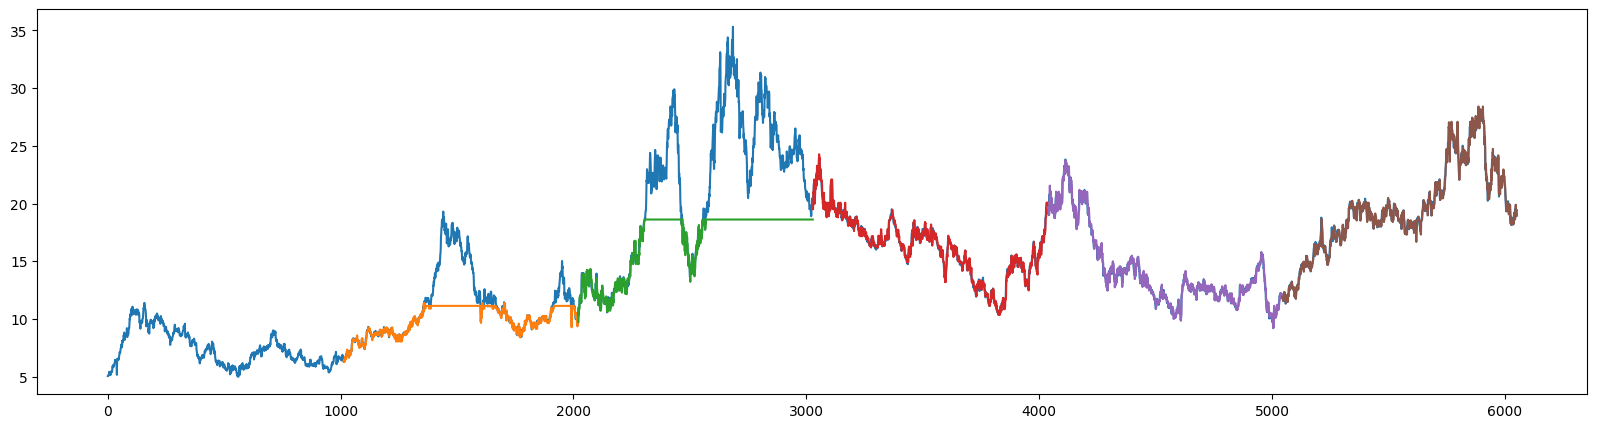

In [2]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

df_shifted = pd.DataFrame({
    'y-1': data['Sugar'].shift(1),  
    'y': data['Sugar'].shift(0),     
    'y+1': data['Sugar'].shift(-1)
}).dropna().reset_index(drop=True)

ts_cv = TimeSeriesSplit().split(df_shifted) # get split indices for walk-forward validation

fig, ax = plt.subplots(figsize=(20, 5)) #create plt figure
ax.plot(df_shifted['y+1'])

# train and test model with walk-forward validation
for i, (train_idx, test_idx) in enumerate(ts_cv):

    # split dataset
    train_x = df_shifted.iloc[train_idx].drop('y+1', axis=1) 
    train_y = df_shifted.iloc[train_idx]['y+1']
    test_x = df_shifted.iloc[test_idx].drop('y+1', axis=1)
    test_y = df_shifted.iloc[test_idx]['y+1']

    # train model
    xgb = XGBRegressor() 
    xgb.fit(train_x, train_y)

    # get forecast
    y_hat = xgb.predict(test_x)
    mae = mean_absolute_error(test_y, y_hat)

    # plot forecast
    ax.plot(test_idx, y_hat)

    # print info
    print(f'cv {i+1}:\ntrain index: {min(train_idx)}-{max(train_idx)}\ntest index: {min(test_idx)}-{max(test_idx)}\nmae: {mae}\n')

fig.show()

It looks great except for those flat lines. It looks like the model is failing to predict values outside of the range seen during training. Let's try an adaptive version of the model that incrementally trains as new data is streamed in. This will allow it to adapt to unseen patterns.

##### Incremental training

c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:16:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:33: You have manually specified the `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
  warnings.warn(smsg, UserWarning)


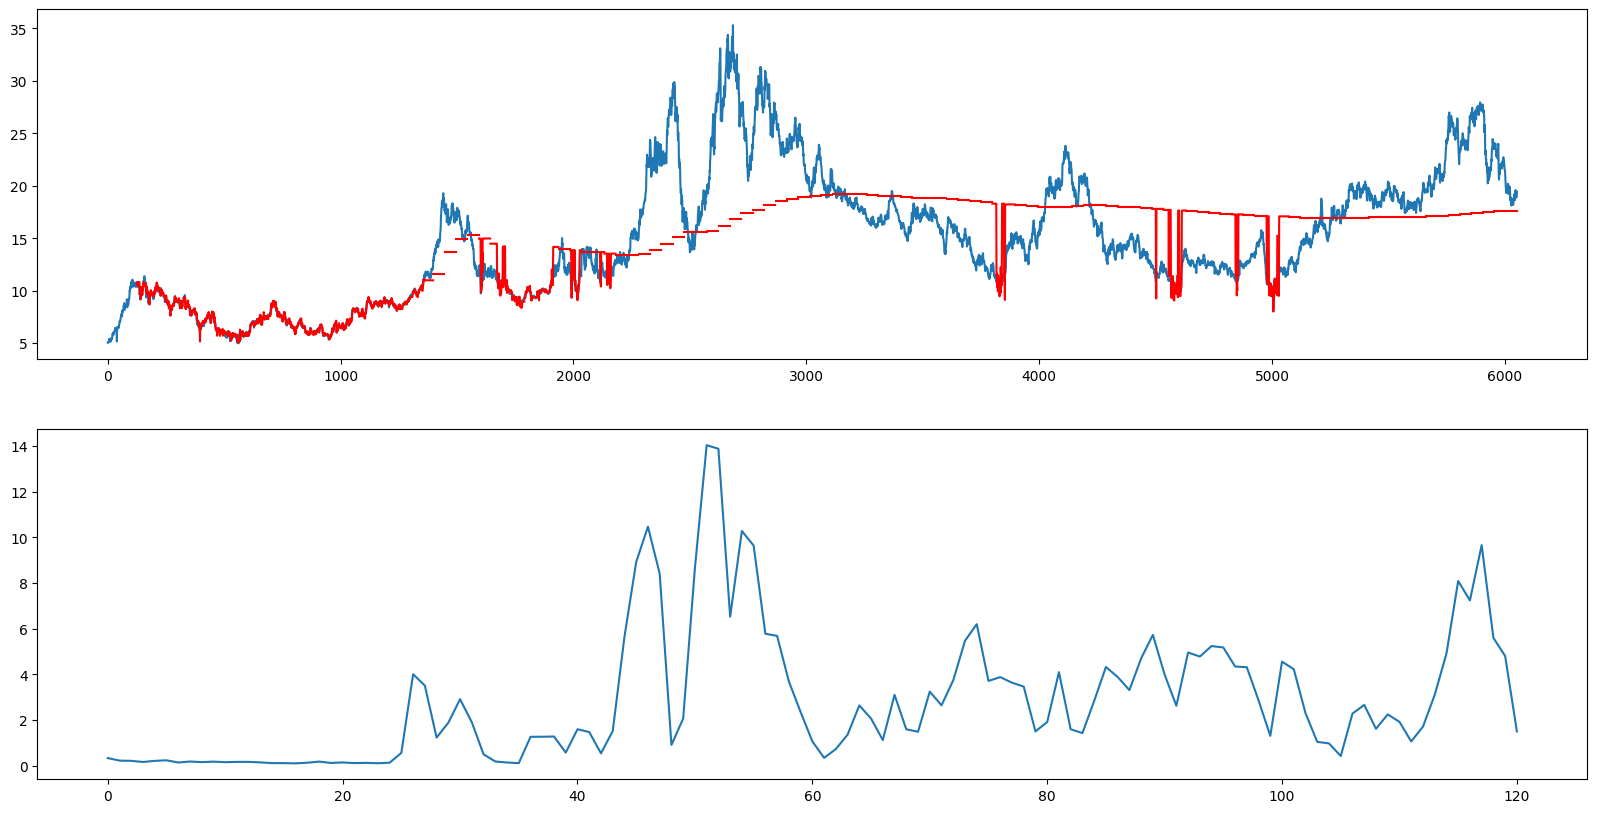

In [3]:
df_shifted = pd.DataFrame({
    'y-1': data['Sugar'].shift(1),  
    'y': data['Sugar'].shift(0),     
    'y+1': data['Sugar'].shift(-1)
}).dropna().reset_index(drop=True)

# get train/test split indices in training batches of length 50
ts_cv = TimeSeriesSplit(n_splits=int(len(df_shifted)/50)).split(df_shifted)

# instantiate incremental regressor
xgb = XGBRegressor(updater='refresh',
           process_type='update',
           refresh_leaf=True,
           tree_method='exact') 

# list to store mae of each iteration
mae_all_itr = []

fig, ax = plt.subplots(2, 1, figsize=(20,10))
ax[0].plot(df_shifted['y+1'])

# for each train/test split
for i, (train_idx, test_idx) in enumerate(ts_cv):

    x_train = df_shifted.iloc[train_idx].drop('y+1', axis=1)
    y_train = df_shifted.iloc[train_idx]['y+1']
    x_test = df_shifted.iloc[test_idx].drop('y+1', axis=1)
    y_test = df_shifted.iloc[test_idx]['y+1']

    if i==0:
        # use default regressor for first iteration
        model = XGBRegressor() 
        model.fit(x_train, y_train)        

    else:
        # train by updating previous model using incremental regressor
        model = xgb.fit(x_train, y_train, xgb_model=model)

    # plot prediction and store mae
    y_hat = model.predict(x_test)
    mae = mean_absolute_error(y_test, y_hat)
    ax[0].plot(test_idx, y_hat, color='red')
    mae_all_itr.append(mae)

# plot the mae for all iterations
ax[1].plot(mae_all_itr)

We're still having the same issue, and it's actually gotten a lot worse! We need to reduce the variability of the target so it has a more even range of values. There are a few transformations that can do this, but I'll exclude ones that don't have an inverse_transform method. This leaves us with quantile transform and power transform. 

Each validation split must be transformed independently from the others. This avoids data leakage and simulates new data being streamed in.

##### Quantile transform

c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (173). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (222). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:33: You have manually specified the `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
  warnings.warn(smsg, UserWarning)
c:\Users\Melanie\

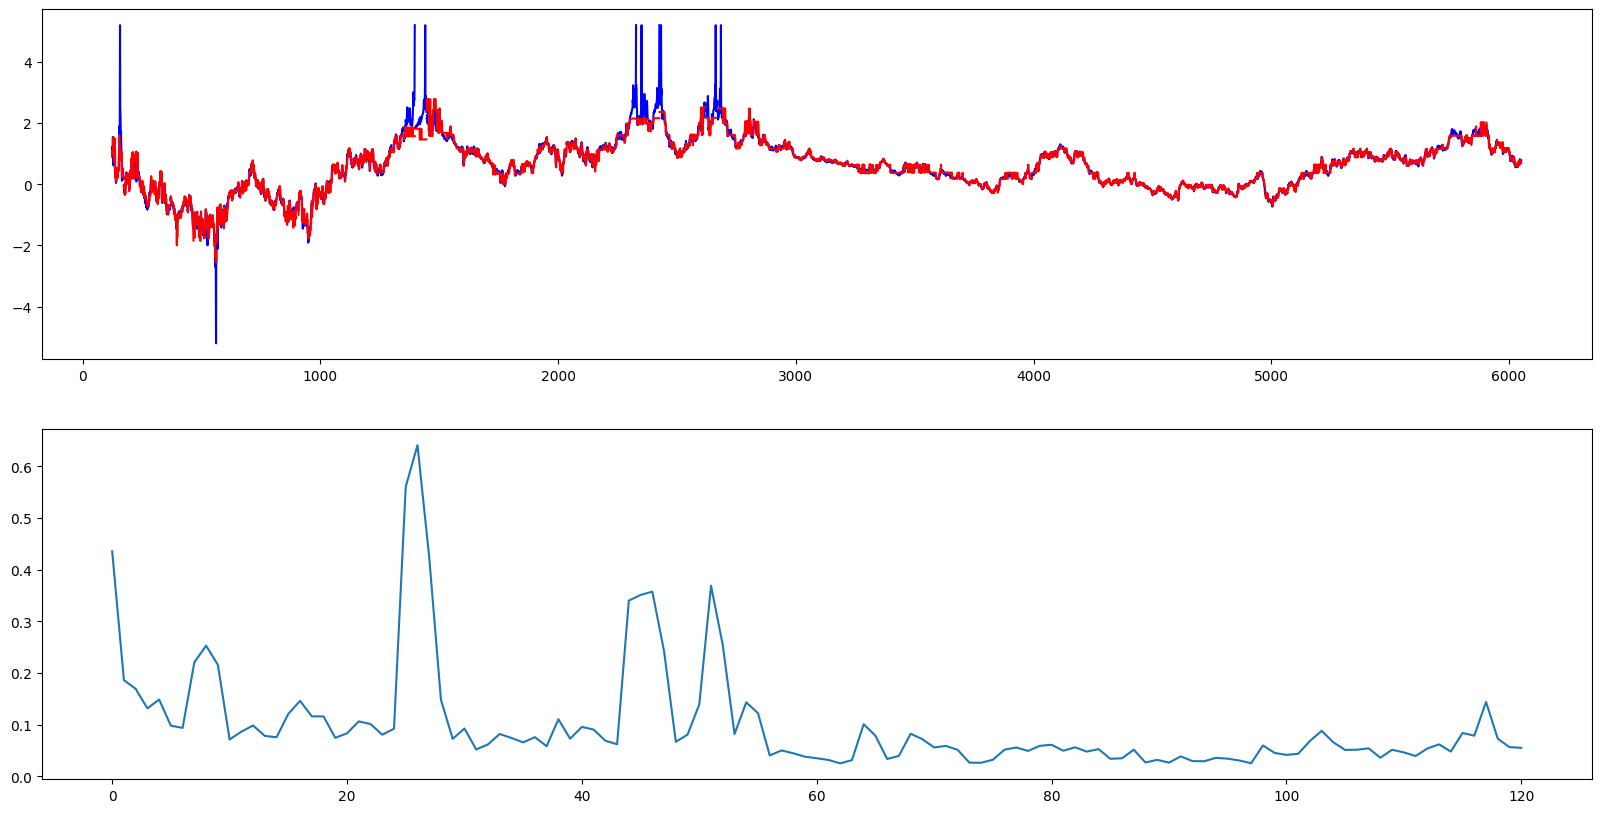

In [3]:
from sklearn.preprocessing import QuantileTransformer

df_shifted = pd.DataFrame({
    'y-1': data['Sugar'].shift(1),  
    'y': data['Sugar'].shift(0),     
    'y+1': data['Sugar'].shift(-1)
}).dropna().reset_index(drop=True)

# get train/test split indices in training batches of length 50
ts_cv = TimeSeriesSplit(n_splits=int(len(df_shifted)/50)).split(df_shifted)

# instantiate incremental regressor
xgb = XGBRegressor(updater='refresh',
           process_type='update',
           refresh_leaf=True,
           tree_method='exact') 

# list to store mae of each iteration
mae_all_itr = []

# quantile transform
qt = QuantileTransformer(output_distribution='normal').set_output(transform='pandas')

fig, ax = plt.subplots(2, 1, figsize=(20,10))

# for each train/test split
for i, (train_idx, test_idx) in enumerate(ts_cv):
    
    # subset data and fit quantile transform
    df_curr = df_shifted.iloc[min(train_idx):max(test_idx)+1]
    df_quantile = qt.fit_transform(df_curr) 

    x_train = df_quantile.loc[train_idx].drop('y+1', axis=1)
    y_train = df_quantile.loc[train_idx]['y+1']
    x_test = df_quantile.loc[test_idx].drop('y+1', axis=1)
    y_test = df_quantile.loc[test_idx]['y+1']

    if i==0:
        # use default regressor for first iteration
        model = XGBRegressor() 
        model.fit(x_train, y_train)        

    else:
        # train by updating previous model using incremental regressor
        model = xgb.fit(x_train, y_train, xgb_model=model)

    # plot prediction and store mae
    y_hat_scaled = model.predict(x_test)
    y_hat_scaled = y_hat_scaled.reshape(-1, 1)
    #y_hat = qt.inverse_transform(y_hat_scaled)
    mae = mean_absolute_error(y_test, y_hat_scaled)
    ax[0].plot(test_idx, y_test, color='blue')
    ax[0].plot(test_idx, y_hat_scaled, color='red')
    mae_all_itr.append(mae)

# plot the mae for all iterations
ax[1].plot(mae_all_itr)


This is far better! The quantile transformation has greatly reduced the variability of the data, minus a few large outliers. The model fits the data very well aside from these outliers. There are still a few flat sections, but they're very short. This isn't a really a big deal since in practice we'll be forecasting farther in the future (due to the nature of futures contacts). It's not very important to predict if an outlier will occur tomorrow. 

##### Power transform

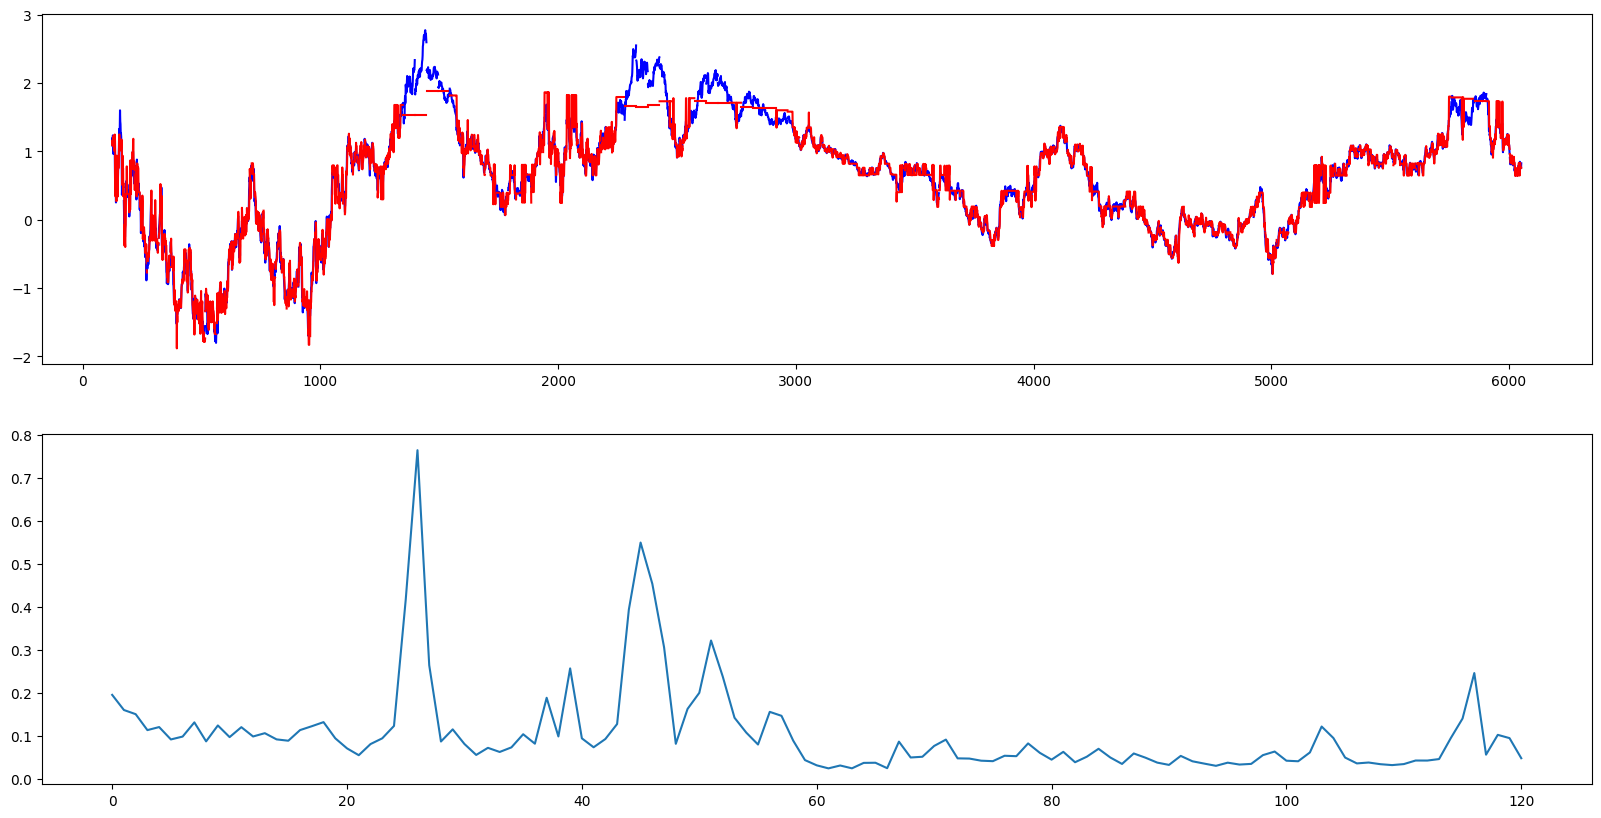

In [5]:
from sklearn.preprocessing import PowerTransformer

# get train/test split indices in training batches of length 50
ts_cv = TimeSeriesSplit(n_splits=int(len(df_shifted)/50)).split(df_shifted)

# instantiate incremental regressor
xgb = XGBRegressor(updater='refresh',
           process_type='update',
           refresh_leaf=True,
           tree_method='exact') 

# list to store mae of each iteration
mae_all_itr = []

# quantile transform
pt = PowerTransformer(method='box-cox').set_output(transform='pandas')

fig, ax = plt.subplots(2, 1, figsize=(20,10))

# for each train/test split
for i, (train_idx, test_idx) in enumerate(ts_cv):
    
    # subset data and fit quantile transform
    df_curr = df_shifted.iloc[min(train_idx):max(test_idx)+1]
    df_power = pt.fit_transform(df_curr) 

    x_train = df_power.loc[train_idx].drop('y+1', axis=1)
    y_train = df_power.loc[train_idx]['y+1']
    x_test = df_power.loc[test_idx].drop('y+1', axis=1)
    y_test = df_power.loc[test_idx]['y+1']

    if i==0:
        # use default regressor for first iteration
        model = XGBRegressor() 
        model.fit(x_train, y_train)        

    else:
        # train by updating previous model using incremental regressor
        model = xgb.fit(x_train, y_train, xgb_model=model)

    # plot prediction and store mae
    y_hat_scaled = model.predict(x_test)
    y_hat_scaled = y_hat_scaled.reshape(-1, 1)
    #y_hat = pt.inverse_transform(y_hat_scaled)
    mae = mean_absolute_error(y_test, y_hat_scaled)
    ax[0].plot(test_idx, y_test, color='blue')
    ax[0].plot(test_idx, y_hat_scaled, color='red')
    mae_all_itr.append(mae)

# plot the mae for all iterations
ax[1].plot(mae_all_itr)

While this does reduce the variability, the predictions still flatten at the peaks. Also, it runs noticeably slower than the quantile transform. We will proceed with the quantile transform.

#### Long range prediction

In futures investing, we need to predict the price of the commodity at the end of the contract. We buy if the current price is lower than that. Thus, we need to be able to forecast longer windows. Futures contracts have standardized expiration dates. First we'll start with a simple approach. We'll simply replace y+1 with y+50 for the target, add lags from 1 through 50, and add rolling statistics. Let's see what this naive approach gets us.

In [38]:
# create new dataframe with lags from 1 to 50 as features and y+50 as the target

df_50 = df_shifted.copy(deep=True)
df_50.drop(['y+1'], axis=1, inplace=True)

for lag in range(2, 51):
    df_50['y-'+str(lag)] = data['Sugar'].shift(lag)

df_50['y+50'] = data['Sugar'].shift(-50)
# creates about 20 NaN rows in y+50, remove them
df_50.dropna(axis=0, subset=['y+50'], inplace=True, ignore_index=True)


# function to calculate slope of regression line during window
def rolling_trend(x):
    idx = np.arange(len(x))
    slope, _ = np.polyfit(idx, x, 1)
    return slope

# add rolling statistics
df_50['rolling_trend'] = df_50['y'].rolling(50).apply(rolling_trend, raw=True)
df_50['rolling_mean'] = df_50['y'].rolling(50).mean()
df_50['rolling_median'] = df_50['y'].rolling(50).median()
df_50['rolling_sum'] = df_50['y'].rolling(50).sum()
df_50['rolling_std'] = df_50['y'].rolling(50).std()
df_50['rolling_var'] = df_50['y'].rolling(50).var()
df_50['rolling_range'] = df_50['y'].rolling(50).max() - df_50['y'].rolling(50).min()
df_50['rolling_skew'] = df_50['y'].rolling(window=50).skew()
df_50['rolling_kurt'] = df_50['y'].rolling(window=50).kurt()
df_50['rolling_iqr'] = df_50['y'].rolling(50).quantile(0.75) - df_50['y'].rolling(50).quantile(0.25)
df_50['ewm_std'] = df_50['y'].ewm(span=50).std()
df_50['rolling_zscore'] = (df_50['y'] - df_50['rolling_mean']) / df_50['rolling_std']

df_50

,y-1,y,y-2,y-3,y-4,y-5,y-6,y-7,y-8,y-9,...,rolling_median,rolling_sum,rolling_std,rolling_var,rolling_range,rolling_skew,rolling_kurt,rolling_iqr,ewm_std,rolling_zscore
0,5.080000,4.960000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.960000,5.050000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063640,NaN
2,5.050000,5.040000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.048783,NaN
3,5.040000,5.070000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.047593,NaN
4,5.070000,5.120000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.057638,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6023,19.590000,19.430000,21.740000,21.110001,21.080000,20.850000,20.900000,20.580000,21.76,20.60,...,19.290000,969.129995,0.916996,0.840881,3.860001,1.060119,1.047200,1.032499,1.421231,0.051691
6024,19.430000,18.980000,21.700001,21.740000,21.110001,21.080000,20.850000,20.900000,20.58,21.76,...,19.265000,966.119995,0.837702,0.701745,3.460001,0.972117,0.999528,0.997499,1.397479,-0.408738
6025,18.980000,18.920000,21.410000,21.700001,21.740000,21.110001,21.080000,20.850000,20.90,20.58,...,19.235000,963.449995,0.772788,0.597201,3.360001,0.914439,1.129218,0.929999,1.374890,-0.451611
6026,18.920000,18.889999,21.760000,21.410000,21.700001,21.740000,21.110001,21.080000,20.85,20.90,...,19.219999,960.849995,0.704772,0.496703,3.330000,0.767932,0.990885,0.905000,1.352941,-0.463981


c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (197). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (246). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (295). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (344). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessin

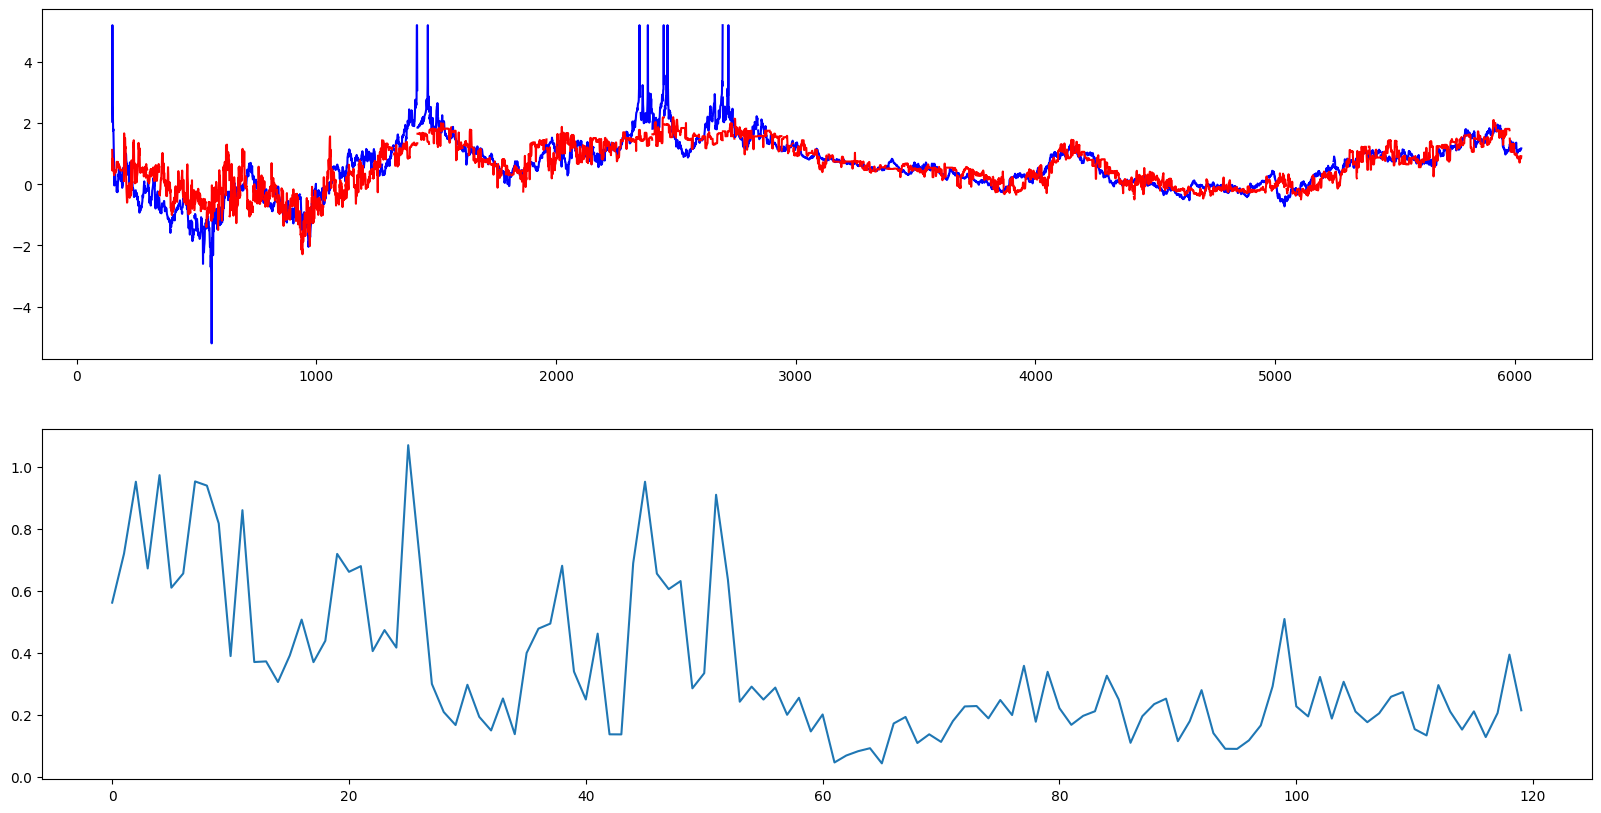

In [39]:

# get train/test split indices in training batches of length 50
ts_cv = TimeSeriesSplit(n_splits=int(len(df_50)/50)).split(df_50)

# list to store mae of each iteration
mae_all_itr = []

fig, ax = plt.subplots(2, 1, figsize=(20,10))

# for each train/test split
for i, (train_idx, test_idx) in enumerate(ts_cv):
    
    # subset data and fit quantile transform
    df_curr = df_50.iloc[min(train_idx):max(test_idx)+1]
    df_quantile = qt.fit_transform(df_curr) 

    x_train = df_quantile.loc[train_idx].drop('y+50', axis=1)
    y_train = df_quantile.loc[train_idx]['y+50']
    x_test = df_quantile.loc[test_idx].drop('y+50', axis=1)
    y_test = df_quantile.loc[test_idx]['y+50']

    if i==0:
        # use default regressor for first iteration
        model = XGBRegressor() 
        model.fit(x_train, y_train)        

    else:
        # train by updating previous model using incremental regressor
        model = xgb.fit(x_train, y_train, xgb_model=model)

    # plot prediction and store mae
    y_hat_scaled = model.predict(x_test)
    y_hat_scaled = y_hat_scaled.reshape(-1, 1)
    #y_hat = qt.inverse_transform(y_hat_scaled)
    try:
        mae = mean_absolute_error(y_test, y_hat_scaled)
    except:
        print(test_idx)
        print(y_test)
    ax[0].plot(test_idx, y_test, color='blue')
    ax[0].plot(test_idx, y_hat_scaled, color='red')
    mae_all_itr.append(mae)

# plot the mae for all iterations
ax[1].plot(mae_all_itr)


It could be better. Let's try a recursive approach, where for each increment of y+n where n is in [1, 50], a model predicts y+n and feeds it to the next model which predicts y+n+1. The issue with this approach is that errors will be compounded. It's worth a shot.

In [61]:
# add y+n target values
for lag in range(1, 50):
    df_50['y+'+str(lag)] = data['Sugar'].shift(-lag)

all_targets = ['y+'+str(n) for n in range(1,51)]

df_50.dropna(axis=0, subset=all_targets, inplace=True, ignore_index=True)

c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (179). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (228). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (277). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (326). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessin

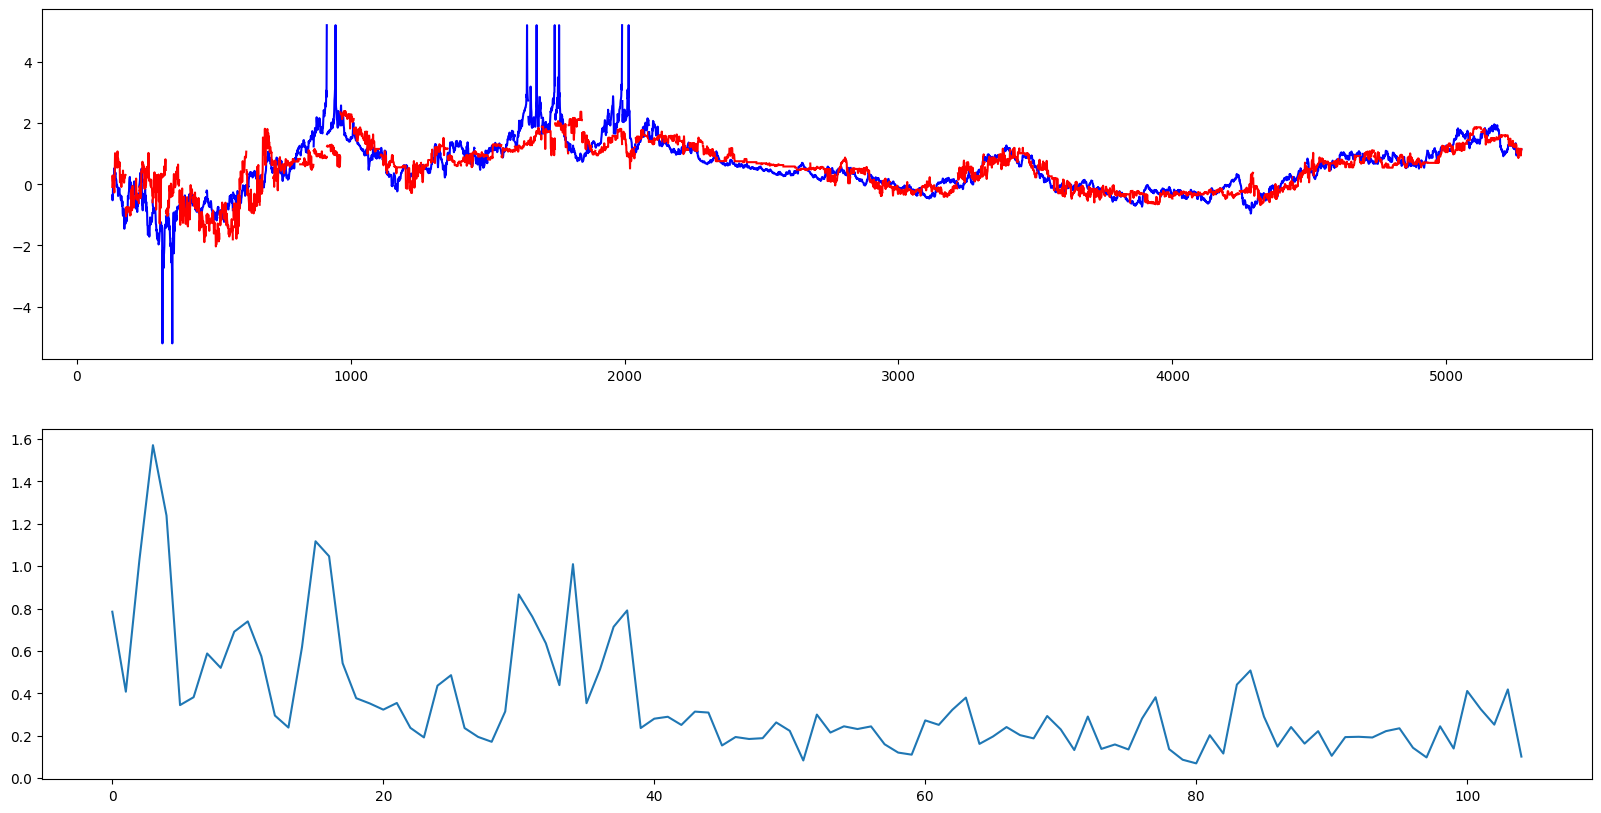

In [ ]:
# get train/test split indices in training batches of length 50
ts_cv = TimeSeriesSplit(n_splits=int(len(df_50)/50)).split(df_50)

# list to store mae of each iteration
mae_all_itr = []

fig, ax = plt.subplots(2, 1, figsize=(20,10))

# for each train/test split
for i, (train_idx, test_idx) in enumerate(ts_cv):

    df_curr = df_50.iloc[min(train_idx):max(test_idx)+1]
    df_qt = qt.fit_transform(df_curr) 
    x_train = df_qt.loc[train_idx].drop(all_targets, axis=1)
    x_test = df_qt.loc[test_idx].drop(all_targets, axis=1)
    
    for n in range(1,51):
        
        y_train = df_qt.loc[train_idx]['y+'+str(n)]
        y_test = df_qt.loc[test_idx]['y+'+str(n)]

        if i==0 and n==1:
            # use default regressor for the absolute first iteration
            model = XGBRegressor() 
            model.fit(x_train, y_train)        

        else:
            # train by updating previous model using incremental regressor
            model = xgb.fit(x_train, y_train, xgb_model=model)

        # make prediction
        y_hat_scaled = model.predict(x_test)

        # add prediction as a feature
        

    # plot prediction and store mae
    y_hat_scaled = model.predict(x_test)
    y_hat_scaled = y_hat_scaled.reshape(-1, 1)
    #y_hat = qt.inverse_transform(df_qt, set_output='pandas')['y+50']
    try:
        mae = mean_absolute_error(y_test, y_hat_scaled)
    except:
        print(test_idx)
        print(y_test)
    ax[0].plot(test_idx, y_test, color='blue')
    ax[0].plot(test_idx, y_hat_scaled, color='red')
    mae_all_itr.append(mae)

# plot the mae for all iterations
ax[1].plot(mae_all_itr)

It's worse now. 

### Feature selection

In [6]:
# generate a bunch of new features

import numpy as np

df_shifted = pd.DataFrame({
    'y-1': data['Sugar'].shift(1),  
    'y': data['Sugar'].shift(0),     
    'y+1': data['Sugar'].shift(-1)
}).dropna().reset_index(drop=True)

# set rolling window sizes (days)
window=7 
big_window = 28

# function to calculate slope of regression line during window
def rolling_trend(x):
    idx = np.arange(len(x))
    slope, _ = np.polyfit(idx, x, 1)
    return slope

# get rolling statistics
df_shifted['rolling_trend'] = df_shifted['y'].rolling(window=window).apply(rolling_trend, raw=True)
df_shifted['rolling_mean'] = df_shifted['y'].rolling(window=window).mean()
df_shifted['rolling_median'] = df_shifted['y'].rolling(window=window).median()
df_shifted['rolling_sum'] = df_shifted['y'].rolling(window=window).sum()
df_shifted['rolling_std'] = df_shifted['y'].rolling(window=window).std()
df_shifted['rolling_var'] = df_shifted['y'].rolling(window=window).var()
df_shifted['rolling_min'] = df_shifted['y'].rolling(window=window).min()
df_shifted['rolling_max'] = df_shifted['y'].rolling(window=window).max()
df_shifted['rolling_range'] = df_shifted['rolling_max'] - df_shifted['rolling_min']
df_shifted['rolling_skew'] = df_shifted['y'].rolling(window=big_window).skew()
df_shifted['rolling_kurt'] = df_shifted['y'].rolling(window=big_window).kurt()
df_shifted['rolling_25th'] = df_shifted['y'].rolling(window=big_window).quantile(0.25)
df_shifted['rolling_75th'] = df_shifted['y'].rolling(window=big_window).quantile(0.75)
df_shifted['rolling_iqr'] = df_shifted['rolling_75th'] - df_shifted['rolling_25th']
df_shifted['ewm_std'] = df_shifted['y'].ewm(span=big_window).std()
df_shifted['rolling_zscore'] = (df_shifted['y'] - df_shifted['rolling_mean']) / df_shifted['rolling_std']

# get longer lags
for lag in [3, 7, 14, 28]:
    df_shifted[f'y-{lag}'] = data['Sugar'].shift(lag)

# get other commodities
for col in ['Cocoa', 'Cotton', 'Lumber', 'Coffee']:
    df_shifted[col] = data[col]

df_shifted

,y-1,y,y+1,rolling_trend,rolling_mean,rolling_median,rolling_sum,rolling_std,rolling_var,rolling_min,...,ewm_std,rolling_zscore,y-3,y-7,y-14,y-28,Cocoa,Cotton,Lumber,Coffee
0,5.080000,4.960000,5.050000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,830.0,51.070000,NaN,116.500000
1,4.960000,5.050000,5.040000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.063640,NaN,NaN,NaN,NaN,NaN,836.0,50.730000,NaN,116.250000
2,5.050000,5.040000,5.070000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.048348,NaN,NaN,NaN,NaN,NaN,831.0,51.560001,NaN,118.599998
3,5.040000,5.070000,5.120000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.047024,NaN,NaN,NaN,NaN,NaN,841.0,52.080002,NaN,116.849998
4,5.070000,5.120000,5.160000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.057293,NaN,NaN,NaN,NaN,NaN,853.0,53.959999,NaN,114.150002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6048,19.590000,19.430000,18.980000,0.081429,19.108571,19.10,133.760000,0.339089,0.114981,18.629999,...,0.796619,0.947920,21.110001,20.580000,21.430000,26.860001,4206.0,80.180000,NaN,181.149994
6049,19.430000,18.980000,18.920000,0.083571,19.074286,19.00,133.520000,0.338076,0.114295,18.629999,...,0.769021,-0.278891,21.740000,20.900000,20.920000,26.040001,4274.0,81.360001,NaN,184.050003
6050,18.980000,18.920000,18.889999,0.056429,19.062857,18.98,133.440001,0.342331,0.117191,18.629999,...,0.742974,-0.417307,21.700001,20.850000,20.240000,25.090000,4323.0,81.309998,NaN,180.000000
6051,18.920000,18.889999,18.969999,-0.023929,19.100000,18.98,133.700001,0.298887,0.089333,18.790001,...,0.718161,-0.702609,21.410000,21.080000,20.620001,25.809999,4429.0,81.330002,NaN,185.250000


c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (173). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (222). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (271). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (320). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessin

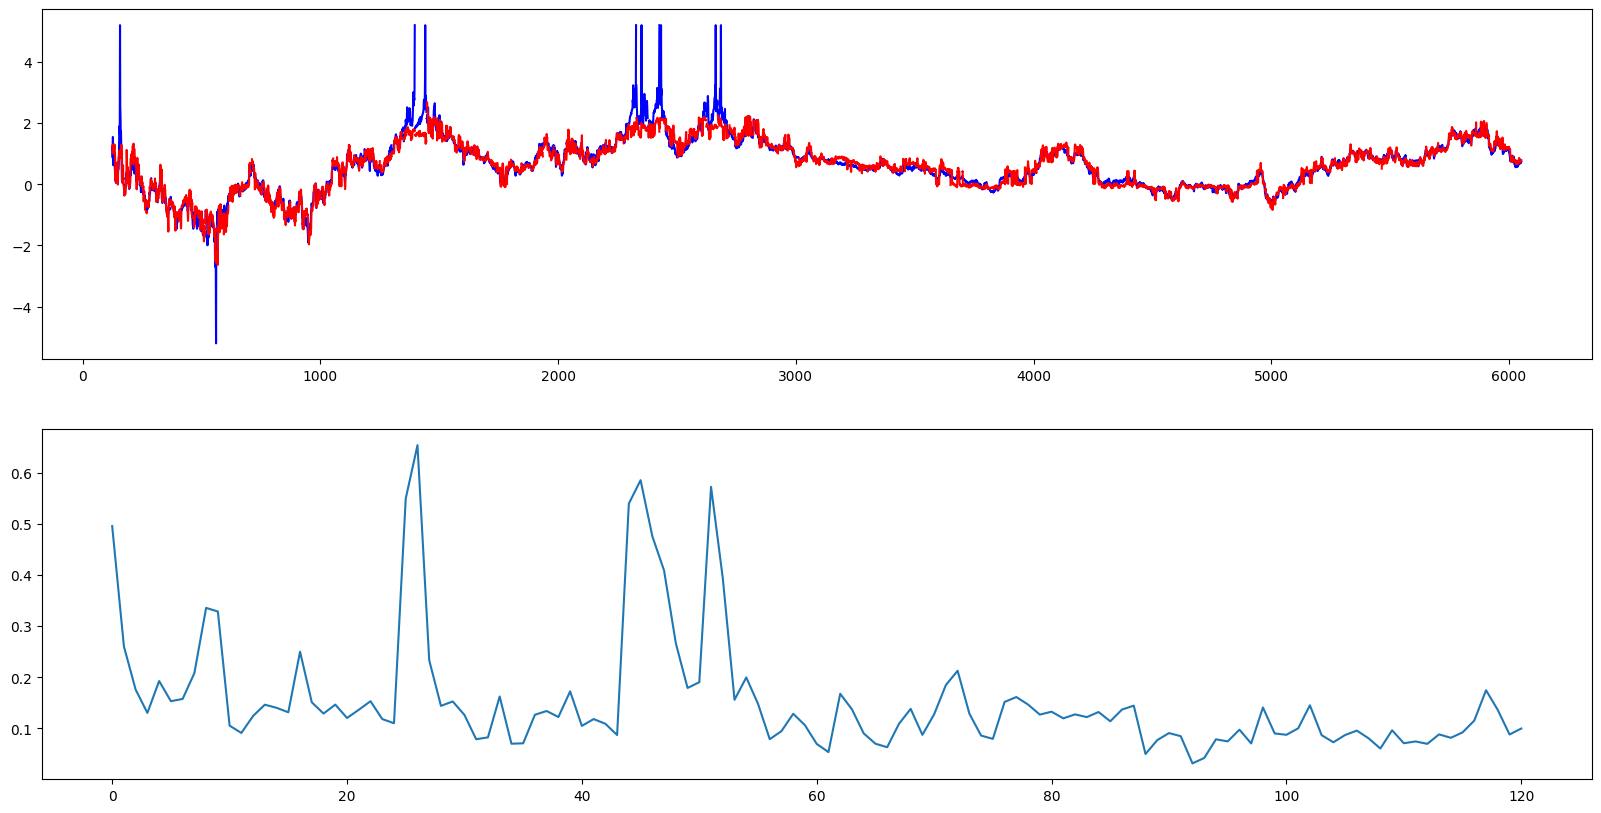

In [7]:
# re-train and evaluate model using expanded feature set

# get train/test split indices in training batches of length 50
ts_cv = TimeSeriesSplit(n_splits=int(len(df_shifted)/50)).split(df_shifted)

# instantiate incremental regressor
xgb = XGBRegressor(updater='refresh',
           process_type='update',
           refresh_leaf=True,
           tree_method='exact') 

# list to store mae of each iteration
mae_all_itr = []

# quantile transform
qt = QuantileTransformer(output_distribution='normal').set_output(transform='pandas')

fig, ax = plt.subplots(2, 1, figsize=(20,10))

# for each train/test split
for i, (train_idx, test_idx) in enumerate(ts_cv):
    
    # subset data and fit quantile transform
    df_curr = df_shifted.iloc[min(train_idx):max(test_idx)+1]
    df_quantile = qt.fit_transform(df_curr) 

    x_train = df_quantile.loc[train_idx].drop('y+1', axis=1)
    y_train = df_quantile.loc[train_idx]['y+1']
    x_test = df_quantile.loc[test_idx].drop('y+1', axis=1)
    y_test = df_quantile.loc[test_idx]['y+1']

    if i==0:
        # use default regressor for first iteration
        model = XGBRegressor() 
        model.fit(x_train, y_train)        

    else:
        # train by updating previous model using incremental regressor
        model = xgb.fit(x_train, y_train, xgb_model=model)

    # plot prediction and store mae
    y_hat_scaled = model.predict(x_test)
    y_hat_scaled = y_hat_scaled.reshape(-1, 1)
    #y_hat = qt.inverse_transform(y_hat_scaled)
    mae = mean_absolute_error(y_test, y_hat_scaled)
    ax[0].plot(test_idx, y_test, color='blue')
    ax[0].plot(test_idx, y_hat_scaled, color='red')
    mae_all_itr.append(mae)

# plot the mae for all iterations
ax[1].plot(mae_all_itr)

The MAE at the peaks are smaller than before. It also took much longer to run. Let's prune out the features that aren't so useful.

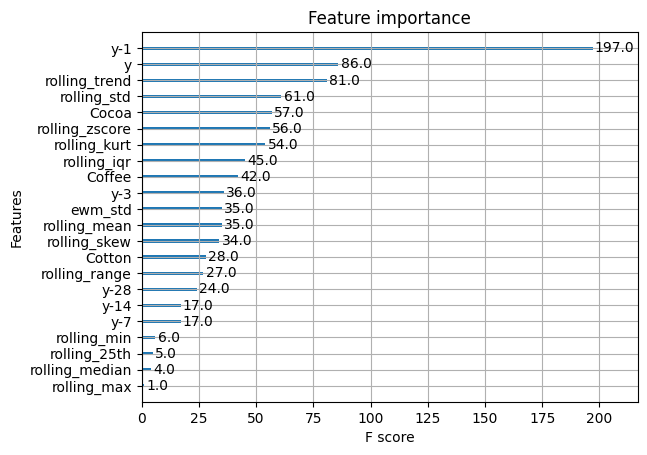

In [8]:
from xgboost import plot_importance

ax = plot_importance(xgb)
plt.show()

In [ ]:
# get the features ranked by importance
y_labs = ax.get_yticklabels()

# create new dataframe with only the target 
test_df = pd.DataFrame(df_shifted['y+1'])

# create vars to store info during iteration
mae_all = {} # store the average mae resulting from adding the feature

# quantile transform
qt = QuantileTransformer(output_distribution='normal').set_output(transform='pandas')

# instantiate incremental regressor
xgb = XGBRegressor(updater='refresh',
           process_type='update',
           refresh_leaf=True,
           tree_method='exact') 

# for every feature in order of descending importance
#for label in y_labs[::-1]:
for label in y_labs[0:1]:

    # get train/test split indices
    ts_cv = TimeSeriesSplit(n_splits=int(len(df_shifted)/50))
    splits = ts_cv.split(df_shifted)

    # convert matplotlib text object to str
    col = label.get_text()

    # add feature to testing dataframe
    test_df[col] = df_shifted[col].copy(deep=True)
    
    # create array to store the mae value from every train/test split
    mae = np.empty(ts_cv.get_n_splits())

    # train and test model with walk-forward validation

    # for each train/test split
    for i, (train_idx, test_idx) in enumerate(splits):

        # subset data and fit quantile transform
        df_curr = df_shifted.iloc[min(train_idx):max(test_idx)+1]
        df_quantile = qt.fit_transform(df_curr) 

        x_train = df_quantile.loc[train_idx].drop('y+1', axis=1)
        y_train = df_quantile.loc[train_idx]['y+1']
        x_test = df_quantile.loc[test_idx].drop('y+1', axis=1)
        y_test = df_quantile.loc[test_idx]['y+1']

        if i==0:
            # use default regressor for first iteration
            model = XGBRegressor() 
            model.fit(x_train, y_train)        

        else:
            # train by updating previous model using incremental regressor
            model = xgb.fit(x_train, y_train, xgb_model=model)

        # plot prediction and store mae
        y_hat_scaled = model.predict(x_test)
        y_hat_scaled = y_hat_scaled.reshape(-1, 1)
        #y_hat = qt.inverse_transform(y_hat_scaled)
        mae[i] = mean_absolute_error(y_test, y_hat_scaled)

    # get the mean mae across the five splits
    mae_all[label.get_text()] = mae.mean()

    

c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (173). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (222). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (271). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (320). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Melanie\anaconda3\envs\new_conda\Lib\site-packages\sklearn\preprocessin

In [11]:
mae_all

{'y-1': np.float64(0.154416152044619),
 'y': np.float64(0.154416152044619),
 'rolling_trend': np.float64(0.154416152044619),
 'rolling_std': np.float64(0.154416152044619),
 'Cocoa': np.float64(0.154416152044619),
 'rolling_zscore': np.float64(0.154416152044619),
 'rolling_kurt': np.float64(0.154416152044619),
 'rolling_iqr': np.float64(0.154416152044619),
 'Coffee': np.float64(0.154416152044619),
 'y-3': np.float64(0.154416152044619),
 'ewm_std': np.float64(0.154416152044619),
 'rolling_mean': np.float64(0.154416152044619),
 'rolling_skew': np.float64(0.154416152044619),
 'Cotton': np.float64(0.154416152044619),
 'rolling_range': np.float64(0.154416152044619),
 'y-28': np.float64(0.154416152044619),
 'y-14': np.float64(0.154416152044619),
 'y-7': np.float64(0.154416152044619),
 'rolling_min': np.float64(0.154416152044619),
 'rolling_25th': np.float64(0.154416152044619),
 'rolling_median': np.float64(0.154416152044619),
 'rolling_max': np.float64(0.154416152044619)}

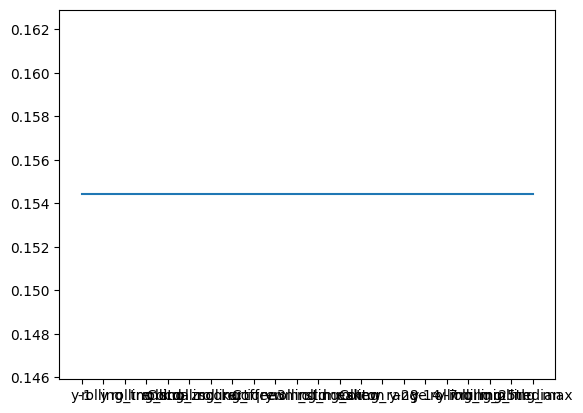

In [ ]:
plot_data = pd.DataFrame({'feature': [col for col in mae_all.keys()], 
                          'mae': [val[1] for val in mae_all.items()]})

plt.plot(plot_data['feature'], plot_data['mae_change'])

### Tuning

In [7]:
from sklearn.model_selection import GridSearchCV

##### learning_rate and n_estimators

In [51]:
# TUNE LEARNING RATE
# DEFAULT = 0.3

params = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
		  'n_estimators': [100, 500, 1000]}

ts_cv = TimeSeriesSplit().split(df_shifted)

gs = GridSearchCV(estimator=xgb,
                  param_grid=params,
                  scoring='neg_mean_absolute_error',
                  cv=ts_cv)

gs_result = gs.fit(df_shifted.drop('y', axis=1), df_shifted['y'])

means = gs_result.cv_results_['mean_test_score']
stds = gs_result.cv_results_['std_test_score']
params = gs_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

-5.041561 (3.162713) with: {'learning_rate': 0.0001, 'n_estimators': 100}
-4.894250 (3.109232) with: {'learning_rate': 0.0001, 'n_estimators': 500}
-4.718009 (3.045653) with: {'learning_rate': 0.0001, 'n_estimators': 1000}
-4.717862 (3.045593) with: {'learning_rate': 0.001, 'n_estimators': 100}
-3.579074 (2.630040) with: {'learning_rate': 0.001, 'n_estimators': 500}
-2.672841 (2.275873) with: {'learning_rate': 0.001, 'n_estimators': 1000}
-2.666437 (2.274935) with: {'learning_rate': 0.01, 'n_estimators': 100}
-1.424491 (1.697490) with: {'learning_rate': 0.01, 'n_estimators': 500}
-1.415251 (1.673008) with: {'learning_rate': 0.01, 'n_estimators': 1000}
-1.420625 (1.663081) with: {'learning_rate': 0.1, 'n_estimators': 100}
-1.439306 (1.664333) with: {'learning_rate': 0.1, 'n_estimators': 500}
-1.444349 (1.660930) with: {'learning_rate': 0.1, 'n_estimators': 1000}
-1.402001 (1.649841) with: {'learning_rate': 0.2, 'n_estimators': 100}
-1.417095 (1.645970) with: {'learning_rate': 0.2, 'n_es

The best learning rate is 0.3 (default) and the best n_estimators is 100 (low).

In [52]:
# FINE-TUNE LEARNING RATE AROUND 0.3 AND N_ESTIMATORS < 100

params = {'learning_rate': [0.25, 0.3, 0.35, 0.4, 0.45],
		  'n_estimators': [50, 75, 100]}

ts_cv = TimeSeriesSplit().split(df_shifted)

gs = GridSearchCV(estimator=xgb,
                  param_grid=params,
                  scoring='neg_mean_absolute_error',
                  cv=ts_cv)

gs_result = gs.fit(df_shifted.drop('y', axis=1), df_shifted['y'])

means = gs_result.cv_results_['mean_test_score']
stds = gs_result.cv_results_['std_test_score']
params = gs_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

-1.397283 (1.648364) with: {'learning_rate': 0.25, 'n_estimators': 50}
-1.400775 (1.646363) with: {'learning_rate': 0.25, 'n_estimators': 75}
-1.403838 (1.648718) with: {'learning_rate': 0.25, 'n_estimators': 100}
-1.371975 (1.602392) with: {'learning_rate': 0.3, 'n_estimators': 50}
-1.378331 (1.606552) with: {'learning_rate': 0.3, 'n_estimators': 75}
-1.380894 (1.601138) with: {'learning_rate': 0.3, 'n_estimators': 100}
-1.348618 (1.556456) with: {'learning_rate': 0.35, 'n_estimators': 50}
-1.348614 (1.542502) with: {'learning_rate': 0.35, 'n_estimators': 75}
-1.347733 (1.539989) with: {'learning_rate': 0.35, 'n_estimators': 100}
-1.410160 (1.637718) with: {'learning_rate': 0.4, 'n_estimators': 50}
-1.411243 (1.635239) with: {'learning_rate': 0.4, 'n_estimators': 75}
-1.415544 (1.632263) with: {'learning_rate': 0.4, 'n_estimators': 100}
-1.482104 (1.676609) with: {'learning_rate': 0.45, 'n_estimators': 50}
-1.485871 (1.674010) with: {'learning_rate': 0.45, 'n_estimators': 75}
-1.49090

The best learning rate is 0.35 and the best n_estimators is 50. 

In [54]:
# FINE-TUNE N_ESTIMATORS AROUND 50

params = {'learning_rate': [0.35],
		  'n_estimators': [10, 20, 30, 40, 50]}

ts_cv = TimeSeriesSplit().split(df_shifted)

gs = GridSearchCV(estimator=xgb,
                  param_grid=params,
                  scoring='neg_mean_absolute_error',
                  cv=ts_cv)

gs_result = gs.fit(df_shifted.drop('y', axis=1), df_shifted['y'])

means = gs_result.cv_results_['mean_test_score']
stds = gs_result.cv_results_['std_test_score']
params = params['n_estimators']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

-1.377506 (1.622576) with: 10
-1.337917 (1.552200) with: 20
-1.344677 (1.550289) with: 30
-1.342970 (1.548593) with: 40
-1.348618 (1.556456) with: 50


The n_estimators is 20.

##### max_depth

In [55]:
# TUNE MAX_DEPTH
# DEFAULT = 6

params = {'learning_rate': [0.35],
		  'n_estimators': [20],
		  'max_depth': [2, 6, 10]}

ts_cv = TimeSeriesSplit().split(df_shifted)

gs = GridSearchCV(estimator=xgb,
                  param_grid=params,
                  scoring='neg_mean_absolute_error',
                  cv=ts_cv)

gs_result = gs.fit(df_shifted.drop('y', axis=1), df_shifted['y'])

means = gs_result.cv_results_['mean_test_score']
stds = gs_result.cv_results_['std_test_score']
params = params['max_depth']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

-1.420199 (1.601418) with: 2
-1.337917 (1.552200) with: 6
-1.397802 (1.557273) with: 10


In [57]:
# FINE TUNE MAX_DEPTH AROUND 6

params = {'learning_rate': [0.35],
		  'n_estimators': [20],
		  'max_depth': [5, 6, 7]}

ts_cv = TimeSeriesSplit().split(df_shifted)

gs = GridSearchCV(estimator=xgb,
                  param_grid=params,
                  scoring='neg_mean_absolute_error',
                  cv=ts_cv)

gs_result = gs.fit(df_shifted.drop('y', axis=1), df_shifted['y'])

means = gs_result.cv_results_['mean_test_score']
stds = gs_result.cv_results_['std_test_score']
params = params['max_depth']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

-1.422315 (1.733122) with: 5
-1.337917 (1.552200) with: 6
-1.426508 (1.647564) with: 7


The best max_depth is 6 (default).

##### min_child_weight

In [58]:
# TUNE MIN_CHILD_WEIGHT
# DEFAULT = 1

params = {'learning_rate': [0.35],
		  'n_estimators': [20],
		  'max_depth': [6],
		  'min_child_weight': [0.001, 0.1, 1, 3, 5]}

ts_cv = TimeSeriesSplit().split(df_shifted)

gs = GridSearchCV(estimator=xgb,
                  param_grid=params,
                  scoring='neg_mean_absolute_error',
                  cv=ts_cv)

gs_result = gs.fit(df_shifted.drop('y', axis=1), df_shifted['y'])

means = gs_result.cv_results_['mean_test_score']
stds = gs_result.cv_results_['std_test_score']
params = params['min_child_weight']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

-1.337917 (1.552200) with: 0.001
-1.337917 (1.552200) with: 0.1
-1.337917 (1.552200) with: 1
-1.363267 (1.562205) with: 3
-1.328668 (1.589827) with: 5


The mae increases then decreases. The best value from this set is 5.

In [61]:
# FINE TUNE MIN_CHILD_WEIGHT < 5

params = {'learning_rate': [0.35],
		  'n_estimators': [20],
		  'max_depth': [6],
		  'min_child_weight': [3.5, 4, 4.5, 5, 5.5, 6, 7]}

ts_cv = TimeSeriesSplit().split(df_shifted)

gs = GridSearchCV(estimator=xgb,
                  param_grid=params,
                  scoring='neg_mean_absolute_error',
                  cv=ts_cv)

gs_result = gs.fit(df_shifted.drop('y', axis=1), df_shifted['y'])

means = gs_result.cv_results_['mean_test_score']
stds = gs_result.cv_results_['std_test_score']
params = params['min_child_weight']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

-1.351212 (1.594694) with: 3.5
-1.351212 (1.594694) with: 4
-1.328668 (1.589827) with: 4.5
-1.328668 (1.589827) with: 5
-1.376252 (1.669760) with: 5.5
-1.376252 (1.669760) with: 6
-1.378927 (1.681970) with: 7


Strange, it might be a fluke. We'll proceed with testing both 1 (default) and 5.

##### min_split_loss

In [63]:
# TUNE MIN_SPLIT_LOSS (GAMMA)
# DEFAULT = 0

params = {'learning_rate': [0.35],
		  'n_estimators': [20],
		  'max_depth': [6],
		  'min_child_weight': [1, 5],
		  'min_split_loss': [0, 1, 5]}

ts_cv = TimeSeriesSplit().split(df_shifted)

gs = GridSearchCV(estimator=xgb,
                  param_grid=params,
                  scoring='neg_mean_absolute_error',
                  cv=ts_cv)

gs_result = gs.fit(df_shifted.drop('y', axis=1), df_shifted['y'])

means = gs_result.cv_results_['mean_test_score']
stds = gs_result.cv_results_['std_test_score']
params = gs_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

-1.337917 (1.552200) with: {'learning_rate': 0.35, 'max_depth': 6, 'min_child_weight': 1, 'min_split_loss': 0, 'n_estimators': 20}
-1.374247 (1.696384) with: {'learning_rate': 0.35, 'max_depth': 6, 'min_child_weight': 1, 'min_split_loss': 1, 'n_estimators': 20}
-1.391293 (1.736083) with: {'learning_rate': 0.35, 'max_depth': 6, 'min_child_weight': 1, 'min_split_loss': 5, 'n_estimators': 20}
-1.328668 (1.589827) with: {'learning_rate': 0.35, 'max_depth': 6, 'min_child_weight': 5, 'min_split_loss': 0, 'n_estimators': 20}
-1.372412 (1.697570) with: {'learning_rate': 0.35, 'max_depth': 6, 'min_child_weight': 5, 'min_split_loss': 1, 'n_estimators': 20}
-1.387423 (1.738638) with: {'learning_rate': 0.35, 'max_depth': 6, 'min_child_weight': 5, 'min_split_loss': 5, 'n_estimators': 20}


The best min_split_loss is 0 (default). 

##### colsample_bytree

In [ ]:
# TUNE COLSAMPLE_BYTREE
# DEFAULT = 1

params = {'learning_rate': [0.35],
		  'n_estimators': [20],
		  'max_depth': [6],
		  'min_child_weight': [1, 5],
		  'min_split_loss': [0],
		  'colsample_bytree': [0.1, 0.5, 1]}

ts_cv = TimeSeriesSplit().split(df_shifted)

gs = GridSearchCV(estimator=xgb,
                  param_grid=params,
                  scoring='neg_mean_absolute_error',
                  cv=ts_cv)

gs_result = gs.fit(df_shifted.drop('y', axis=1), df_shifted['y'])

means = gs_result.cv_results_['mean_test_score']
stds = gs_result.cv_results_['std_test_score']
params = gs_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

-2.933283 (1.401342) with: {'colsample_bytree': 0.1, 'learning_rate': 0.35, 'max_depth': 6, 'min_child_weight': 1, 'min_split_loss': 0, 'n_estimators': 20}
-2.926764 (1.389392) with: {'colsample_bytree': 0.1, 'learning_rate': 0.35, 'max_depth': 6, 'min_child_weight': 5, 'min_split_loss': 0, 'n_estimators': 20}
-2.282267 (1.507705) with: {'colsample_bytree': 0.5, 'learning_rate': 0.35, 'max_depth': 6, 'min_child_weight': 1, 'min_split_loss': 0, 'n_estimators': 20}
-2.190122 (1.515923) with: {'colsample_bytree': 0.5, 'learning_rate': 0.35, 'max_depth': 6, 'min_child_weight': 5, 'min_split_loss': 0, 'n_estimators': 20}
-1.337917 (1.552200) with: {'colsample_bytree': 1, 'learning_rate': 0.35, 'max_depth': 6, 'min_child_weight': 1, 'min_split_loss': 0, 'n_estimators': 20}
-1.328668 (1.589827) with: {'colsample_bytree': 1, 'learning_rate': 0.35, 'max_depth': 6, 'min_child_weight': 5, 'min_split_loss': 0, 'n_estimators': 20}


The best colsample_bytree is 1 (default). 

##### reg_alpha, reg_lamba

In [67]:
# TUNE REG_ALPHA (DEFAULT = 0) AND REG_LAMBDA (DEFAULT = 1)

params = {'learning_rate': [0.35],
		  'n_estimators': [20],
		  'max_depth': [6],
		  'min_child_weight': [1, 5],
		  'min_split_loss': [0],
		  'colsample_bytree': [1],
		  'reg_alpha': [0, 0.001, 0.1, 1, 10],
		  'reg_lambda': [0, 0.001, 0.1, 1, 10]}

ts_cv = TimeSeriesSplit().split(df_shifted)

gs = GridSearchCV(estimator=xgb,
                  param_grid=params,
                  scoring='neg_mean_absolute_error',
                  cv=ts_cv)

gs_result = gs.fit(df_shifted.drop('y', axis=1), df_shifted['y'])

means = gs_result.cv_results_['mean_test_score']
stds = gs_result.cv_results_['std_test_score']
params = gs_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

-1.397596 (1.672087) with: {'colsample_bytree': 1, 'learning_rate': 0.35, 'max_depth': 6, 'min_child_weight': 1, 'min_split_loss': 0, 'n_estimators': 20, 'reg_alpha': 0, 'reg_lambda': 0}
-1.395760 (1.653081) with: {'colsample_bytree': 1, 'learning_rate': 0.35, 'max_depth': 6, 'min_child_weight': 1, 'min_split_loss': 0, 'n_estimators': 20, 'reg_alpha': 0, 'reg_lambda': 0.001}
-1.420809 (1.661818) with: {'colsample_bytree': 1, 'learning_rate': 0.35, 'max_depth': 6, 'min_child_weight': 1, 'min_split_loss': 0, 'n_estimators': 20, 'reg_alpha': 0, 'reg_lambda': 0.1}
-1.337917 (1.552200) with: {'colsample_bytree': 1, 'learning_rate': 0.35, 'max_depth': 6, 'min_child_weight': 1, 'min_split_loss': 0, 'n_estimators': 20, 'reg_alpha': 0, 'reg_lambda': 1}
-1.464478 (1.701681) with: {'colsample_bytree': 1, 'learning_rate': 0.35, 'max_depth': 6, 'min_child_weight': 1, 'min_split_loss': 0, 'n_estimators': 20, 'reg_alpha': 0, 'reg_lambda': 10}
-1.384524 (1.668277) with: {'colsample_bytree': 1, 'learni

The best parameter set, excluding default values, is:

- learning_rate: 0.35
- n_estimators: 20
- min_child_weight: 5

Let's see if the model has improved.

cv 1:
train index: 0-948
test index: 949-1893
mae: 1.4586231161046912

cv 2:
train index: 0-1893
test index: 1894-2838
mae: 4.371733290051657

cv 3:
train index: 0-2838
test index: 2839-3783
mae: 0.3261458200121683

cv 4:
train index: 0-3783
test index: 3784-4728
mae: 0.247227172246055

cv 5:
train index: 0-4728
test index: 4729-5673
mae: 0.23961173466273725



C:\Users\Melanie\AppData\Local\Temp\ipykernel_8752\1109453541.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


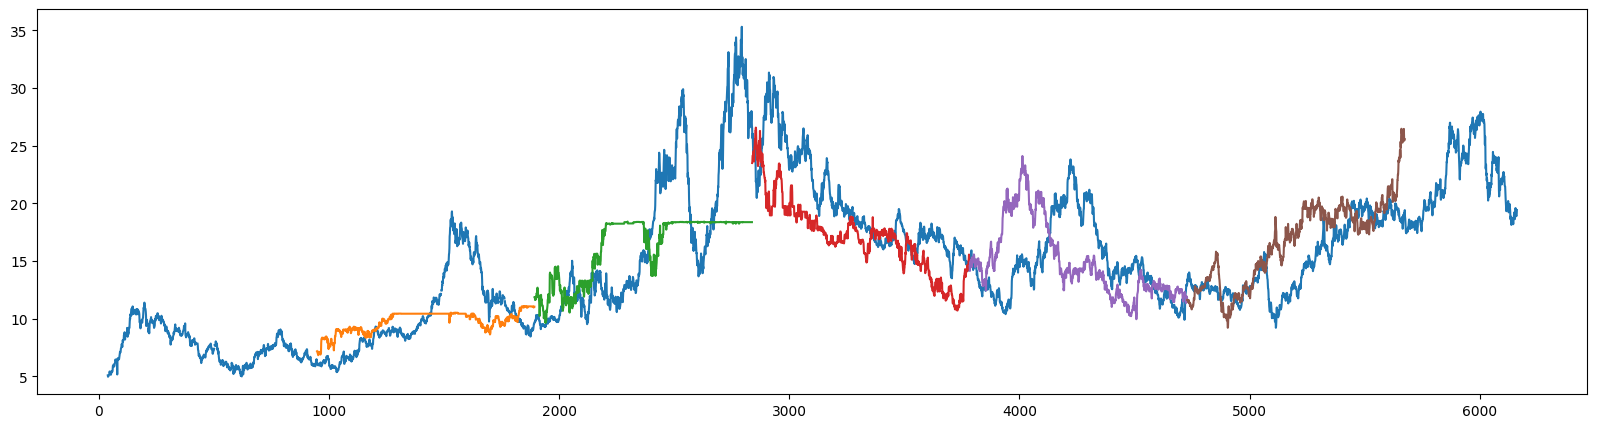

In [69]:
ts_cv = TimeSeriesSplit().split(df_shifted) # get split indices for walk-forward validation

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(data['Sugar'])

# train and test model with walk-forward validation
for i, (train_idx, test_idx) in enumerate(ts_cv):

    # split dataset
    train_x = df_shifted.iloc[train_idx].drop('y', axis=1) 
    train_y = df_shifted.iloc[train_idx]['y']
    test_x = df_shifted.iloc[test_idx].drop('y', axis=1)
    test_y = df_shifted.iloc[test_idx]['y']

    # train model
    xgb = XGBRegressor(objective='reg:squarederror',
                       learning_rate = 0.35,
                       n_estimators=20,
                       min_child_weight=5) 
    xgb.fit(train_x, train_y)

    # get forecast
    y_hat = xgb.predict(test_x)
 
    # calculate and store mae
    mae = mean_absolute_error(test_y, y_hat) 

    ax.plot(test_idx, y_hat)

    print(f'cv {i+1}:\ntrain index: {min(train_idx)}-{max(train_idx)}\ntest index: {min(test_idx)}-{max(test_idx)}\nmae: {mae}\n')

fig.show()


Nah, not really. The average mae is slightly lower at 1.32, but it didn't affect the problem of the model predicting values <i>too soon</i>.

### Probabilistic forecast

### Trading Simulation